# Reconnaissance de chiffre en language des signes avec pytorch

Dans cette exemple d'utilisation de deep learning, nous allons utiliser une base de donnée de 2061 images de mains faisant un chiffre en language des signes. Ces images sont en nuances de gris et dans une de plage de 0 à 1.
Nous disposons également des vérités terrains associés à chaque image sous forme d'un tableau de taille 10 avec un 1 à l'index de la classe correspondante.

Pour effectuer l'apprentissage nous allons utiliser pytorch.

## Chargement des images

In [27]:
#Import des modules pythons nécessaires
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision.utils as vutils
from PIL import Image
import numpy as np
import torch.utils.data as utils
from random import shuffle
import matplotlib.pyplot as plt
from IPython.display import clear_output
#Affichage de la graine d'aléatoire actuelle (afin de reproduire des résultats si nécessaire)
manualSeed = random.randint(1, 10000)
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
#Chargement de cuda
device = torch.device("cuda:0")

Random Seed:  8806


Avant d'aller plus en profondeur avec des réseaux de neurone il faut tout d'abord charger les données.
Pour cela nous chargons directement les images via numpy et pour et les vérités terrains nous avons décider de ramener le tableau à 1 unique valeur représentant l'axe.

<PIL.Image.Image image mode=L size=32x32 at 0x7FD4DD5CBE48>
Classes :  0.0


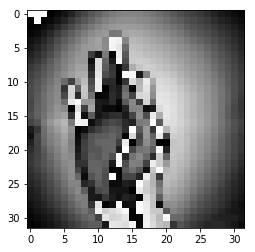

In [8]:
#Chargement des images
#L'image est d'abord redimmensionnée
#Puis noramlisé entre -0.5 et 0.5
Trans = transforms.Compose([
            transforms.Resize(32),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,)),
        ])
images = [Trans(Image.fromarray(im)) for im in np.load("./datas/X.npy")]
#Chargement des classes
temp = np.load("./datas/Y.npy")
classes = np.zeros(len(images))
for i in range(len(classes)):
    classes[i] = temp[i].nonzero()[0][0]
plt.imshow(transforms.ToPILImage()(images[0]))
print(transforms.ToPILImage()(images[0]))
print("Classes : ",classes[0])

Pour avoir des datasets cohérents il faut aussi mélanger les données de bases

In [9]:
#Mélange du dataset
temp_s = []
for i in range(len(classes)):
    temp_s.append([images[i],classes[i] ])
shuffle(temp_s)
for i in range(len(classes)):
    [im,c] = temp_s[i]
    images[i] = im
    classes[i] = c

Maintenant que nous avons nore dataset il faut le partitionner pour avoir un ensemble pour l'entraînement
et un pour les tests (afin de vérifier que notre réseau n'apprend pas par coeur)

In [10]:
#Définition des partitions du dataset
#Nous choisissons de prendre un dataset d'entrainement représentant 80% des données
prc_train = int(0.80*len(images))
prc_test = prc_train + int(0.2*len(images))
#Chargement des partitions
def load():
    out = []
    prc = [prc_train,prc_test]
    for i in range(len(prc)):
        if i == 0:
            images_train = [(im) for im in images[:prc[i]]]
            classes_train = classes[:prc_train]
        #elif i == len(prc)-1:
        #    images_train = [(im) for im in images[prc[i]:]]
        #    classes_train = classes[prc[i]:]
        else:
            images_train = [(im) for im  in images[prc[i-1]:prc[i]]]
            classes_train = classes[prc_train:prc_test]
        tensor_x_train = torch.stack([torch.Tensor(i) for i in images_train])
        tensor_y_train = torch.from_numpy(classes_train).long()
        datas_train = utils.TensorDataset(tensor_x_train,tensor_y_train)
        dataloader_train = utils.DataLoader(datas_train,50, shuffle=True)
        out.append(dataloader_train)
    return out
[dataloader_train,dataloader_test] = load()

Ensuite il faut définir les fonctions d'entraînements et de test associé pour entraîner nos réseaux

In [35]:
def train(model, dataloader_train, optimizer, epoch, criterion):
    model.train()
    sum_loss = 0
    for i, (data,target) in enumerate(dataloader_train, 0):
        data, target = data.to(device), target.to(device)
        #print(target)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        #print(output)
        loss.backward()
        sum_loss += loss.item()
        optimizer.step()
        #if i % 10 == 0:
        #    print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        #        epoch, i * len(data), len(dataloader_train.dataset),
        #        100. * i / len(dataloader_train), loss.item()))
        return loss.item()
    
def test(model, test_loader,criterion,epoch,max_epoch):
    clear_output(wait=True)
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for i, (data,target) in enumerate(test_loader, 0):
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target, reduction='sum').item() # somme des batchs
            pred = output.argmax(dim=1, keepdim=True) # récupération l'index de la meilleure proba
            correct += pred.eq(target.view_as(pred)).sum().item()#Comparaison à la vérité
    test_loss /= len(test_loader.dataset)
    print('Test set[{}/{}]: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        epoch,max_epoch,
        test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))
    sys.stdout.flush()
    return test_loss, 100. * correct / len(test_loader.dataset)

## Réseau full connected

Maintenant nous pouvons passer à la définition de notre réseau, nous allons tout d'abord commencer avec un perceptron multicouche.

In [25]:
class Net_FC(nn.Module):
    def __init__(self):
        super(Net_FC, self).__init__()
        self.fc1 = nn.Linear(32*32,200)
        self.fc2 = nn.Linear(200, 10)

    def forward(self, x):
        x = x.view(-1,32*32)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return F.log_softmax(x, dim=1)
criterion = nn.NLLLoss()
model = Net_FC().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

Il est maintenant temps de lancer notre premier apprentissage et voir les résultats

Test set[499/500]: Average loss: 0.4454, Accuracy: 385/412 (93%)

max acc :  96.11650485436893
Used Seed:  8806


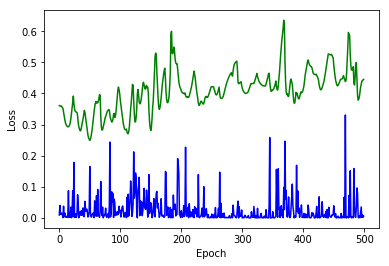

In [36]:
epoch_arr = range(500)
train_loss = []
test_loss = []
max_test = 0
criterion = F.nll_loss
#Entrainement
for epoch in epoch_arr:
    train_loss.append( train(model, dataloader_train, optimizer, epoch, criterion))
    loss,test_prc = test(model, dataloader_test,criterion,epoch,500)
    if test_prc > max_test:
        max_test = test_prc
        torch.save(model.state_dict(), './best_full_connected.pth')
    test_loss.append( loss )
print("max acc : ",max_test)
#Affichage des courbes de loss
plt.plot(epoch_arr,train_loss,'b')
plt.plot(epoch_arr,test_loss,'g')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

Les résultats sont très peu concluant, on peut maintenant esasyer avec un réseau à convolution que l'on termine avec 2 couches full connected.

## Réseau à convolution

In [30]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, 5, 1)
        self.conv2 = nn.Conv2d(64, 128, 5, 1)
        self.fc1 = nn.Linear(5*5*128, 1000)
        self.fc2 = nn.Linear(1000, 10)

    def forward(self, x):
        x= self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 5*5*128)#Modification de la forme des donneés pour les faire rentrer dans les couches full connected
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training) #Utilisation de dropout pour ajouter de l'aléatoire à l'entraienement
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
criterion = nn.NLLLoss()
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

Test set: Average loss: 0.3334, Accuracy: 384/412 (93%)

max acc :  96.35922330097087
Used Seed:  8806


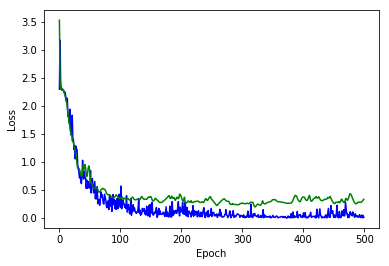

In [31]:
epoch_arr = range(500)
train_loss = []
test_loss = []
max_test = 0
criterion = F.nll_loss
#Entrainement
for epoch in epoch_arr:
    train_loss.append( train(model, dataloader_train, optimizer, epoch, criterion))
    loss,test_prc = test(model, dataloader_test,criterion,epoch,500)
    if test_prc > max_test:
        max_test = test_prc
        torch.save(model.state_dict(), './best_conv.pth')
    test_loss.append( loss )
print("max acc : ",max_test)
#Affichage des courbes de loss
plt.plot(epoch_arr,train_loss,'b')
plt.plot(epoch_arr,test_loss,'g')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

## Réseau residuel

Ici les résultats sont bien meilleurs pouvant atteindre les 95%.

Mais il est possible d'aller encore plus loin avec des architectures bien plus complexes.
Pour cette expérimentation nous allons essayer de construire une architecture de type ResNet (pour Residual Network).
Le principe est simple, après chaque convolution il y a une perte de l'information d'origine, ainsi pour pouvoir conserver ces informations lors du traitement il suffit de sauvegarder les données avant un ensemble de convolution, puis de venir les ajouter à la fin d'un ensemble de convolution. Ce type de d'opération s'appel un block résiduel, dans notre cas nous allons construire des blocks de 2 convolution 3*3, et pour venir injecter les données nous allons simplement faire la somme après la 2ème convolution.
Nous allons également utiliser des batchnorms entre chaque convolution pour améliorer les performances du réseau.
Ensuite notre réseau final sera constitué 4 bloc résiduel suivit de 2 couches full connected pour ramener l'informations à un ensemble traitable.

In [42]:
def conv3x3(in_planes, out_planes, stride=1):
    """Convolution 3*3 conservant la taille initiale de l'image en utilsant un padding de 1"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
padding=1, bias=False)

class ResBlock(nn.Module):
    """Définition d'un bloc résiduel"""
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(ResBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        #Ajoute une couche supplémentaire pour redimenssioner le résidu si il ne possède pas la même
        #forme que la sortie des convolutions
        if inplanes != planes:
            self.downsample = nn.Sequential(nn.Conv2d(inplanes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes))
        else:
            self.downsample = None
        self.stride = stride

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class Net_RES_32(nn.Module):
    def __init__(self):
        super(Net_RES_32, self).__init__()
        self.b1 = ResBlock(1,32)
        self.b2 = ResBlock(32,32)
        self.b3 = ResBlock(32,64)
        self.b4 = ResBlock(64,128)
        self.fc1 = nn.Linear(64*4*4, 300)
        #self.fc1_b = nn.Linear(800, 200)
        self.fc2 = nn.Linear(300, 10)

    def forward(self, x):
        x = self.b1(x)
        x = F.max_pool2d(x,2)

        x = self.b2(x)
        x = F.max_pool2d(x,2)

        x = self.b3(x)
        x = F.max_pool2d(x,2)
        #x = self.b4(x)
        #x = F.max_pool2d(x,2)

        x = x.view(-1,x.shape[1]*x.shape[2]*x.shape[3])
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        #x = F.relu(self.fc1_b(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
criterion = nn.NLLLoss()
model = Net_RES_32().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)


Ce réseau étant bien plus complexe que les précédent nous allons l'entraîner jusqu'à 1000 epoch.

Test set[999/1000]: Average loss: 0.2091, Accuracy: 397/412 (96%)

max acc :  98.54368932038835


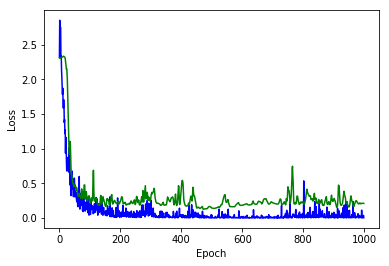

In [43]:
epoch_arr = range(1000)
train_loss = []
test_loss = []
max_test = 0
criterion = F.nll_loss
#Entrainement
for epoch in epoch_arr:
    train_loss.append( train(model, dataloader_train, optimizer, epoch, criterion))
    loss,test_prc = test(model, dataloader_test,criterion,epoch,1000)
    if test_prc > max_test:
        max_test = test_prc
        torch.save(model.state_dict(), './best_res.pth')
    test_loss.append( loss )
print("max acc : ",max_test)
#Affichage des courbes de loss
plt.plot(epoch_arr,train_loss,'b')
plt.plot(epoch_arr,test_loss,'g')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

On peut voir qu'avec cette architecture les résultats sont impressionnant et peuvent atteindre les 99%.

## Utilisation du réseau

Maintenant que nous avons un réseau foncitonnel il est temps de s'en servir !


Prediction :  7


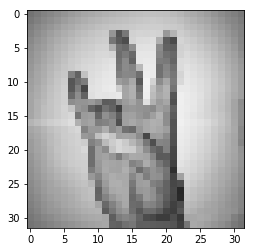

In [44]:
#Extraction et mapping du résultat issu du Tensor (par exemple plusieurs classes représentent un 3)
def map_result(tensor):
    map = {
        0 : 9,
        1 : 0,
        2 : 7,
        3 : 6,
        4 : 1,
        5 : 8,
        6 : 4,
        7 : 3,
        8 : 2,
        9 : 5,
    }
    
    '''
        0 : 3,
        1 : 0,
        2 : 3,
        3 : 3,
        4 : 1,
        5 : 3,
        6 : 4,
        7 : 3,
        8 : 2,
        9 : 5,
    '''
    return map[tensor.argmax(dim=1, keepdim=True)[0][0].item()]
    
    
#Chargement du dernier meilleur model
model.load_state_dict(torch.load("./best_res.pth"))
def test_on(model,path):
    model.eval()
    #Normalisation de l'image
    Trans = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
            ])
    im = Image.open(path).convert('L').resize((32,32))
    plt.imshow(im)
    #Conversion en variable pytorch
    im = torch.autograd.Variable(Trans(im).unsqueeze_(0))
    #Evaluation
    with torch.no_grad():
            im = im.to(device)
            output = model(im)
            print("Prediction : ",map_result(output))
            
#Test sur une image
#Il suffit de changer le chemin pour essayer sur une image.
test_on(model,"./datas/eval/hand_412.png")

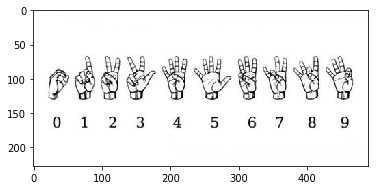

In [22]:
#Affichage d'une image de référence pour vérifier la prédiction
base = Image.open("./datas/eval/base.jpg")
plt.imshow(base)